# Sentence Classifier

In [1]:
import pandas as pd
import pickle
import ast
from sklearn.externals import joblib

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression


In [3]:
def find_factors(text: list, 
                 factors: tuple, 
                 return_count: bool = False) -> list:
    """Find mutual factor intersections for each sentence."""
    sentence_intersections = []
    split_indeces = [i for i, token in enumerate(text) if token == '._PUNCT']
    slice_from = 0
    
    for i, index in enumerate(split_indeces):
        sentence = text[slice_from:index]
        intersections = list()
        
        for el in sentence:
            for j, factor in enumerate(factors):
                if el in factor:
                    intersections.append(j)
        slice_from = index + 1
        if return_count:
            sentence_intersections.append(len(set(intersections)))
        else:
            sentence_intersections.append(intersections)
    return sentence_intersections


def get_labeled_by_factor(t, f2, f3):
    sentence_intersections = []
    sentence_intersections_count = []
    split_indeces = [i for i, x in enumerate(t) if x == "._PUNCT"]
    slice_from = 0
    for i, idx in enumerate(split_indeces):
        sentence = t[slice_from:idx]
        intersections = list()

        for el in sentence:
            if el in f1:
                intersections.append('fac1')
            if el in f2:
                intersections.append('fac2')
                
        slice_from = idx + 1

        if len(set(intersections))==2:
            sentence_intersections.append((sentence, 1))
        else:
            sentence_intersections.append((sentence, 0))
    return sentence_intersections


def confident_average(p1, p2, tau=4):
    if p1 < p2:
        p1, p2 = p2, p1
    return p1 + tau*(1-p1)*(p2-p1)


def standard_blend(p1, p2):
    return (p1 + p2)/2

In [102]:
df = pd.read_csv('../data/tokenized/train.csv')
df['tokens'] = df['tokens'].map(ast.literal_eval)

In [600]:
with open('../data/interm/factors.pickle', 'rb') as f:
    f1, f2, f3 = pickle.load(f)
factors = (f1, f2, f3)

In [31]:
df['f_count'] = df.tokens.map(lambda x: find_factors(x, factors[1:], return_count=True))

In [40]:
filtered_df = df[(df.f_count.map(lambda x: 2 in x)) | (df.target==1)]

## Sentence classifier

#### create dataset

In [46]:
pool = filtered_df.tokens.map(lambda x: get_labeled_by_factor(x, f2, f3)).sum()

In [47]:
train = pd.DataFrame()
train['sentence'] = [el[0] for el in pool]
train['label'] = [el[1] for el in pool]

In [72]:
train.label.value_counts()

0    1475
1      73
Name: label, dtype: int64

In [57]:
train[train.label==1].sample(1).sentence.values

array([list(['как_SCONJ', 'сообщать_VERB', 'китайский_ADJ', 'сми_NOUN', ',_PUNCT', 'в_ADP', 'конец_NOUN', 'февраль_NOUN', 'вдруг_ADV', 'бесследно_ADV', 'исчезать_VERB', 'чжоу::сыян_PROPN', ',_PUNCT', 'генеральный_ADJ', 'директор_NOUN', 'крупный_ADJ', 'элитный_ADJ', 'ресторан_NOUN', 'shu::li::yu::men_PROPN'])],
      dtype=object)

In [70]:
train[train.label==0].sample(1).sentence.values

array([list(['«постановление_NOUN', 'суд_NOUN', 'от_ADP', '15_NUM', 'июль_NOUN', 'суд_NOUN', 'быть_AUX', 'наложить_VERB', 'обеспечительный_ADJ', 'арест_NOUN', 'на_ADP', 'земельный_ADJ', 'участок_NOUN', 'и_CCONJ', 'жилой_ADJ', 'здание_NOUN', 'в_ADP', 'эстепоне_PROPN', '(_PUNCT', 'испания_PROPN', ')_PUNCT', ',_PUNCT', 'принадлежать_VERB', 'мазо_PROPN', 'и_CCONJ', 'он_PRON', 'супруге»_NOUN', ',_PUNCT', '—_PUNCT', 'сообщать_VERB', 'пресс-секретарь_NOUN', 'мосгорсуд_PROPN'])],
      dtype=object)

#### make pipeline

In [516]:
def analyzer(x):
    return x

tfidf_pipeline = make_pipeline(TfidfVectorizer(analyzer=analyzer),
                         LogisticRegression())

In [519]:
tfidf_pipeline.fit(train.sentence, train.label)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=<function analyzer at 0x7f79518611e0>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), norm='l...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [520]:
joblib.dump(tfidf_pipeline, '../models/tfidf_clf.joblib')

['../models/tfidf_clf.joblib']

## Pipeline

In [108]:
def predict_by_sentence(t, clf):
    sentence_intersections = []
    split_indeces = [i for i, x in enumerate(t) if x == "._PUNCT"]
    slice_from = 0
    for i, idx in enumerate(split_indeces):
        sentence = t[slice_from:idx]
        sentence.append('в_ADP')
        intersections = list()
        
        sentence_intersections.append(clf.predict_proba([sentence])[:, 1])
        slice_from = idx + 1

    return sentence_intersections

In [583]:
df = pd.read_csv('../data/interm/factors_clf_top_candidates.csv')
df['tokens'] = df['tokens'].map(ast.literal_eval)

In [584]:
df['sent_preds'] = df['tokens'].map(lambda x: predict_by_sentence(x, tfidf_pipeline))

In [585]:
df['s_preds_max'] = df.sent_preds.map(max)

In [586]:
df.sort_values('s_preds_max', ascending=False, inplace=True)

In [588]:
df['s_preds_max'] = df['s_preds_max'].map(lambda x: x[0])

In [589]:
df['blended_preds'] = df['preds'] + 2*df['s_preds_max']
df.sort_values('blended_preds', ascending=False, inplace=True)

dft = [['index', 'tokens', 'preds', 's_preds_max', 'blended_preds']]

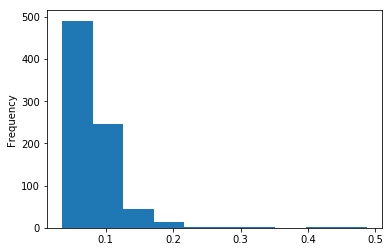

In [590]:
df.s_preds_max.plot(kind='hist');

In [597]:
df.to_csv('../data/interm/final_top.csv', index=False)